# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [3]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Revise
using BayesianModels

using BasicDataLoaders

# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`


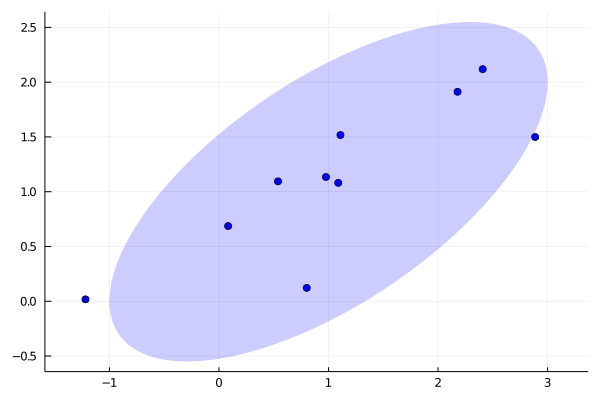

In [4]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[1 0.5; 0.5  0.6]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

X = draw(10, μₓ, Σₓ)

p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [5]:
D = 2
W₀ = Symmetric(Matrix{Float64}(I, D, D))
μ₀ = zeros(D)
Σ₀ = Symmetric(Matrix{Float64}(I, D, D))
pstrength = 1

μ = BayesParam(EFD.Normal(μ₀, pstrength * Σ₀), 
               EFD.Normal(μ₀, pstrength * Σ₀))
Λ = BayesParam(EFD.Wishart(W₀, D - 1 + pstrength), 
               EFD.Wishart(W₀, D - 1 + pstrength))

model = BayesianModels.Normal{D}(μ, Λ)

Normal{2} (
  (μ): BayesParam{ExpFamilyDistributions.Normal{Float64,2}}
  (Λ): BayesParam{ExpFamilyDistributions.Wishart{Float64,2}}
)


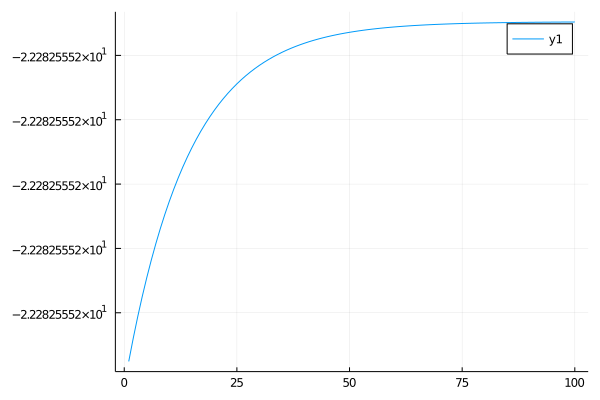

GKS: Possible loss of precision in routine SET_WINDOW


In [11]:
lrate = 0.1
epochs = 100
batchsize = length(X)

elbos = []#[elbo(model, X)]

for epoch in 1:epochs
    dl = DataLoader(shuffle(X), batchsize = batchsize)
    for batch in dl
        gradstep(∇elbo(model, batch, stats_scale = length(dl)), lrate = lrate)
    end
    push!(elbos, elbo(model, dl, detailed = true)[2])
end

plot(elbos)

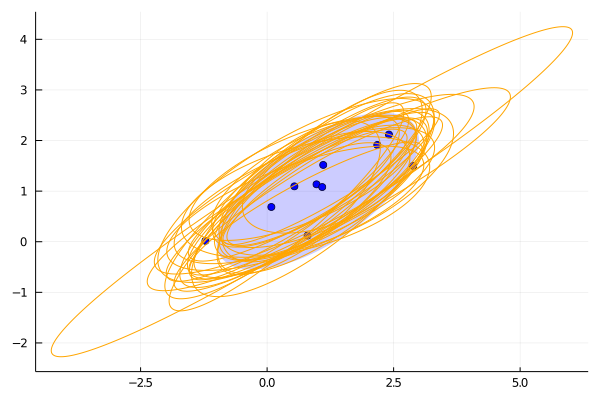

In [16]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(getindex.(X, 1), getindex.(X, 2), color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

for i in 1:30
    μ = EFD.sample(model.μ.posterior)[1]
    Σ = inv(EFD.sample(model.Λ.posterior)[1])
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p